# TDT05 Classification - Challenge 2

## Team: 5_AI-gutta

- Magnus Schjølberg     
- Nicklas Bekkevold

## Table of contents
1. Table of contents
2. Imports and loading the data 
3. Exploratory Data Analysis (EDA)
4. Data Cleaning
5. Feature Engineering
6. Model Choice and Training
7. Prediction
8. Model Interpretation
9. Saving results to file

## TODOs

* Prøve å konvertere null-verdier til 0, og å ha null som en egen kategori
* Teste med både OHE og annen type category encoding 
* Prøve ulike 'predictors'
* Tune den beste 
* Tolke resultatene
* Plotte alle features med rikitg plot i starten

# Imports and loading the data

In [82]:
# Imports
import tensorflow as tf
import pandas as pd
import numpy as np
import seaborn as sns
import shap
import matplotlib.pyplot as plt
from matplotlib import rcParams

print('Tensorflow version:', tf.__version__)

# Config
rcParams['figure.figsize'] = 20, 10  # Make plots bigger
RANDOM_SEED = 42  # For reproducibility

Tensorflow version: 2.6.0


In [83]:
# Loading the data
training_data = pd.read_csv('../input/tdt05-2021-challenge-2/challenge2_train.csv', index_col=0)
X_test = pd.read_csv('../input/tdt05-2021-challenge-2/challenge2_test.csv', index_col=0)

print('Training shape:', training_data.shape)
print('Test shape:', X_test.shape)
summary_statistics = pd.DataFrame(
    {
        'dtype': training_data.dtypes,
        'categories': training_data.nunique(),
        '#nan': training_data.isnull().sum(axis = 0),
    }, 
    index=training_data.columns,
)

print(summary_statistics)
training_data.head(5)

Training shape: (50000, 30)
Test shape: (50000, 29)
          dtype  categories   #nan
target    int64           2      0
f0      float64           2   1459
f1       object         190   1487
f2       object           6   1439
f3      float64           3   1488
f4       object           2   1498
f5      float64          13  11617
f6      float64           2   1490
f7      float64           6   1525
f8       object        2177   1490
f9       object           5   1489
f10      object          26   1501
f11     float64        7633    145
f12      object         222   1541
f13      object          15   1447
f14      object        1204   1451
f15      object         222   1477
f16     float64          12   1460
f17     float64       19209   9762
f18      object           6   1556
f19     float64           6   1437
f20     float64           4   1464
f21     float64           7   1510
f22      object           3   1513
f23      object        1495   1516
f24     float64        4148   2696
f25

,target,f0,f1,f2,f3,f4,f5,f6,f7,f8,...,f19,f20,f21,f22,f23,f24,f25,f26,f27,f28
id,,,,,,,,,,,,,,,,,,,,,
0,0,1.0,gL,e,3.0,A,NaN,0.0,6.0,96ae67d3e,...,0.5,0.0,3.0,R,328b0cf4e,0.834041,T,N,1.0,14.2364
1,0,0.0,Rj,c,1.0,A,7.0,1.0,4.0,9fcf422f2,...,0.4,0.0,1.0,NaN,328b0cf4e,0.686021,T,N,1.0,NaN
2,0,NaN,In,a,1.0,A,10.0,1.0,6.0,a5adff44e,...,0.5,1.0,3.0,G,0c67fcbbd,1.141271,T,N,3.0,NaN
3,1,1.0,rA,c,3.0,A,7.0,1.0,1.0,15c90ab2e,...,0.6,1.0,1.0,G,fee4e3007,0.662382,T,N,3.0,NaN
4,0,1.0,pE,c,3.0,A,7.0,0.0,6.0,b36490559,...,0.5,0.0,1.0,B,587e040bd,-1.000000,T,N,1.0,13.9537


## Configuration variables

The cell below is used for turning on or off numerical encoding for certain "feature groups".

In [84]:
# Configuration variables
should_convert = {
    'hexadecimal': False,
    'alphabetic': False,
    'binary': False,
    'boolean': False,
}

# Exploratory Data Analysis (EDA)

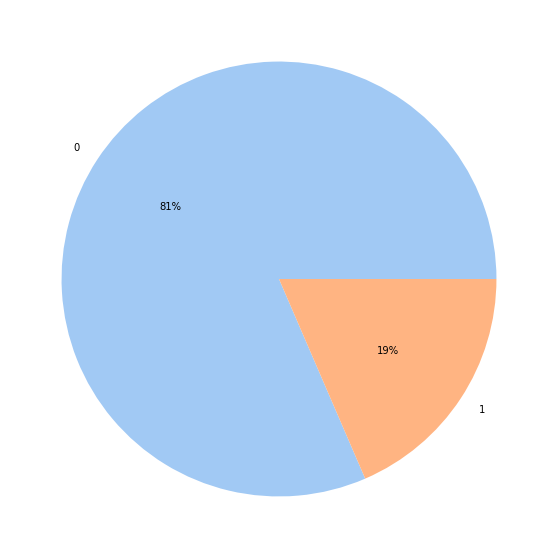

In [85]:
plt.pie(
    training_data['target'].value_counts(), 
    colors=sns.color_palette('pastel')[0:2], 
    labels=['0', '1'],
    autopct='%.0f%%',
)
plt.show()

The target value is 0 or 1, indicating that the task to solve is binary classification.  
There is a lot more of the 0-class (81%) than the 1-class (19%).

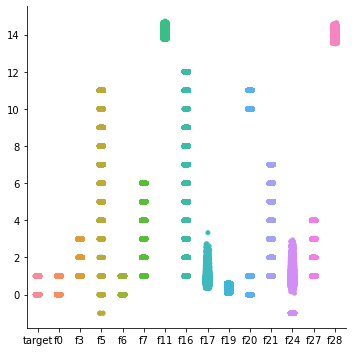

In [86]:
sns.catplot(data=training_data)
plt.show()

It is interesting to see that several of the features has "-1" as a value. This might be an explicit na / null-value set by a user or something similar.  

## Plot feature distributions

We plot all the features to get a feel for the different features.  

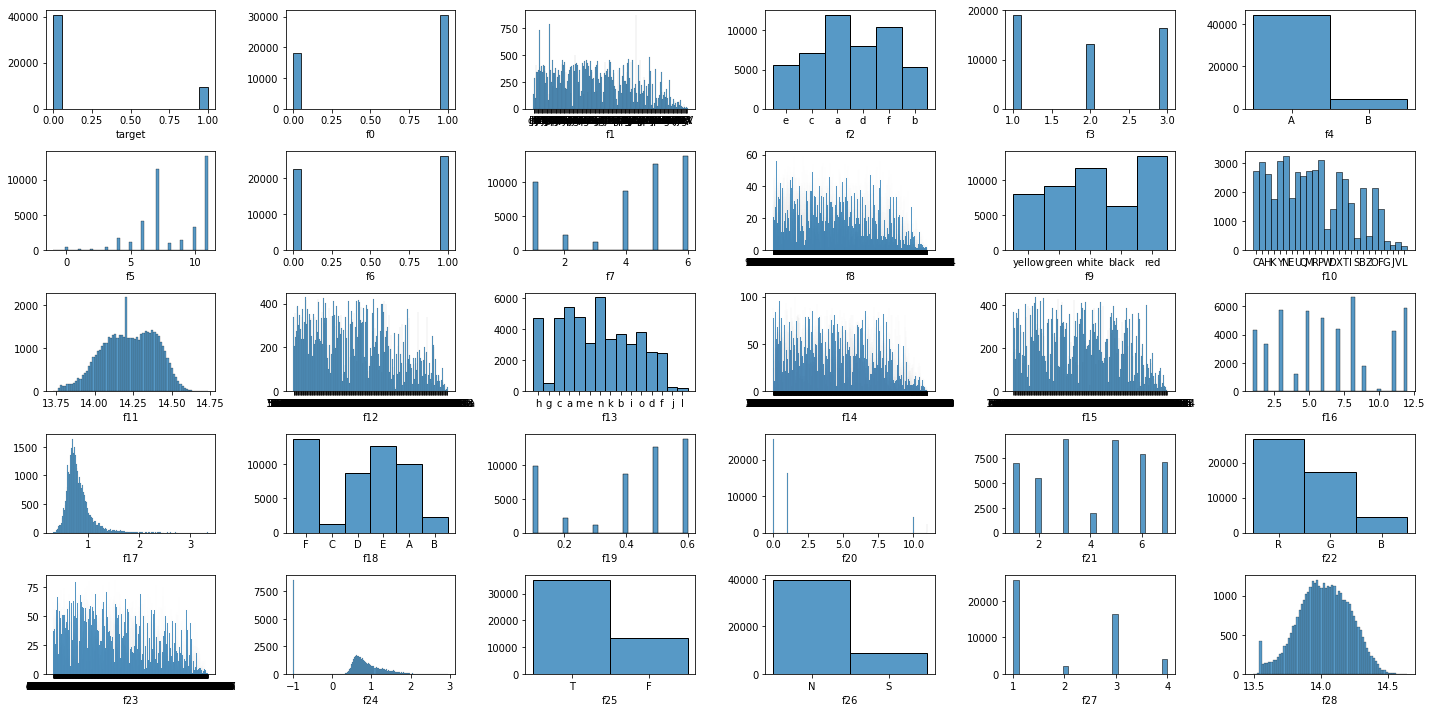

In [87]:
# Plot all features to see their shape
fig, axes = plt.subplots(5, 6)

for i, feature in enumerate(list(training_data.columns)):
    ax = sns.histplot(training_data[feature], ax=axes[i // 6][i % 6])
    ax.set_xlabel(feature)
    ax.set_ylabel('')

fig.tight_layout()
plt.show()

## Feature description

Each feature is listed below with some example values and our notes.  
We have also grouped each feature into categories based on similarities to make preprocessing easier.  
(We also used Kaggle's built in data explorer and Excel to take a look at the features.)

| Feature | Example | Our feature "category" | Note |
| :-- | :-- | :-- | :-- |
| target | 0 or 1 | boolean | This means that the problem is a binary classification |
| f0 | 0.0 or 1.0 | boolean | Could be turned into a categorical feature |
| f1 | gL, Rj, In, ... | categorical | 173 unique two letter pairs, could be country codes or something similar |
| f2 | a, b, ..., f | alphabetic | letters a-f |
| f3 | 1.0, 2.0 or 3.0 | ordinal | ordinal of some kind, should not be converted to categorical |
| f4 | A or B | boolean | mostly As (=88%) |
| f5 | -1, 0, ..., 11 | ordinal | weird distribution, many null values |
| f6 | 0 or 10 | binary | Binary - could be turned into a categorical feature |
| f7 | 1, 2, ..., 6 | ordinal | Ordinal of some kind, should not be converted to categorical |
| f8 | '96ae67d3e', 'a5adff44e' | hexadecimal | Looks like hexadecimal, might be a hash of some kind |
| f9 | red, white, black, green, yellow | categorical | five colors |
| f10 | A, B, ..., Z | alphabetic | Could be converted to integers to get ordinal property |
| f11 | 139681, 140242 | interval |
| f12 | '1c756c04a', '5d1ac7760' | hexadecimal | Looks like hexadecimal, might be a hash of some kind |
| f13 | a, b, ..., o | alphabetic | Could be converted to integers to get ordinal property |
| f14 | '168e51823', '558613041' | hexadecimal | Looks like hexadecimal, might be a hash of some kind |
| f15 | '7861df0a8', '1d88b0a79' | hexadecimal | Looks like hexadecimal, might be a hash of some kind |
| f16 | 0, 10, ..., 120 | ordinal | Ordinal of some kind, should not be converted to categorical |
| f17 | 858314945, 616742978 | interval |  |
| f18 | A, B, ..., F | alphabetic | Could be converted to integers to get ordinal property |
| f19 | 0, 1, ..., 6 | ordinal | Ordinal of some kind, should not be converted to categorical |
| f20 | 00, 01, 10 or 11 | binary | Looks like a binary number. Could be converted to 0, 1, 2 and 3 |
| f21 | 0, 10, ..., 70 | ordinal | Ordinal of some kind, should not be converted to categorical |
| f22 | R, G or B | categorical | Could it be a coincidence that it is RGB? |
| f23 | '328b0cf4e', '0c67fcbbd' | hexadecimal | Looks like hexadecimal, might be a hash of some kind |
| f24 | 834041366, 686021137 | interval |  |
| f25 | T or F | Boolean | Boolean - (T)rue or (F)alse |
| f26 | N or S | Boolean | Boolean - (N)orth or (S)outh? |
| f27 | 1, 2, ..., 4 | ordinal | Ordinal of some kind, should not be converted to categorical |
| f28 | 141855, 139805 | interval |  |


## Feature mean distribution

Check if there is any noticeable groupings in the feature means.

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.


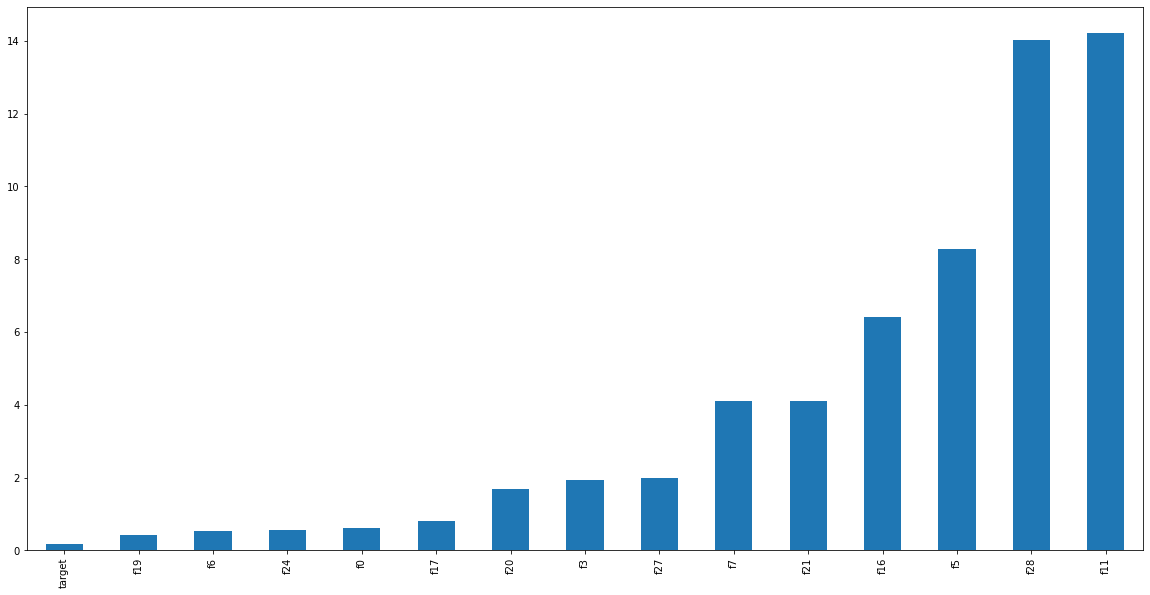

In [88]:
# Plot mean per feature 
training_data.mean(axis=0).sort_values().plot(kind='bar')
plt.show()

Feature f11 and f28 have similar mean values. Let's see if they are correlated.

## Correlation plot

See if there are any interesting patterns in the data.

In [89]:
# Plot correlations using the pearson method
categorical_encoder = lambda x : pd.factorize(x)[0]  # Encodes categorical data for correlation plot 
encoded_training_data = training_data.apply(categorical_encoder)

correlation = encoded_training_data.corr(method='pearson', min_periods=1)
correlation.style.background_gradient(cmap='viridis').set_precision(2)

this method is deprecated in favour of `Styler.format(precision=..)`


,target,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,f12,f13,f14,f15,f16,f17,f18,f19,f20,f21,f22,f23,f24,f25,f26,f27,f28
target,1.00,0.00,0.00,0.01,-0.05,-0.05,-0.01,-0.02,0.03,0.00,-0.04,0.02,-0.01,0.01,0.05,0.00,-0.00,0.04,-0.01,0.05,-0.01,0.00,0.03,0.01,-0.00,-0.00,0.06,-0.02,0.00,-0.00
f0,0.00,1.00,-0.00,0.00,-0.01,0.00,-0.00,0.00,0.00,0.01,0.00,-0.01,0.00,-0.00,0.00,-0.00,0.01,-0.00,-0.01,-0.00,0.00,0.00,0.00,-0.00,-0.00,-0.01,-0.00,-0.00,0.00,0.01
f1,0.00,-0.00,1.00,0.00,-0.00,-0.00,-0.01,-0.00,0.00,0.01,-0.01,0.00,0.01,0.00,-0.00,-0.00,0.00,0.00,-0.00,-0.00,-0.00,0.00,0.01,0.01,0.00,-0.00,0.00,-0.02,0.00,0.01
f2,0.01,0.00,0.00,1.00,-0.00,0.01,-0.01,0.01,0.00,-0.01,-0.00,-0.00,-0.00,0.00,-0.00,0.00,-0.00,-0.00,-0.01,-0.01,0.01,-0.00,0.00,0.01,-0.00,0.01,0.00,0.00,-0.00,-0.00
f3,-0.05,-0.01,-0.00,-0.00,1.00,0.01,0.01,-0.01,0.00,-0.00,-0.00,0.00,0.00,0.01,0.00,-0.00,-0.00,0.00,0.00,-0.00,-0.00,0.00,0.01,-0.00,0.00,0.00,0.00,0.00,0.00,-0.00
f4,-0.05,0.00,-0.00,0.01,0.01,1.00,0.00,0.01,-0.00,0.00,0.01,-0.00,0.01,-0.00,0.00,0.00,0.00,0.01,0.00,0.00,-0.00,0.01,0.01,-0.00,-0.00,-0.00,-0.00,-0.00,0.01,0.01
f5,-0.01,-0.00,-0.01,-0.01,0.01,0.00,1.00,-0.00,0.00,0.01,0.00,0.00,0.00,-0.00,0.00,-0.00,-0.01,-0.00,0.01,0.00,-0.00,0.01,0.00,0.00,-0.01,0.03,-0.00,-0.00,0.01,-0.01
f6,-0.02,0.00,-0.00,0.01,-0.01,0.01,-0.00,1.00,0.01,0.00,0.01,0.00,0.00,0.00,-0.01,-0.01,-0.00,-0.01,-0.00,-0.00,-0.00,0.00,0.01,0.00,-0.00,-0.00,0.01,0.00,0.00,0.00
f7,0.03,0.00,0.00,0.00,0.00,-0.00,0.00,0.01,1.00,0.00,-0.01,0.00,-0.00,-0.00,0.00,-0.00,0.01,0.00,0.01,-0.00,-0.00,-0.00,0.01,0.00,0.00,0.00,0.00,0.00,-0.00,-0.00
f8,0.00,0.01,0.01,-0.01,-0.00,0.00,0.01,0.00,0.00,1.00,0.00,0.00,0.04,0.00,-0.01,0.02,0.00,0.00,0.03,0.01,0.01,-0.01,-0.00,-0.00,0.02,0.03,-0.00,-0.00,-0.01,0.03


f11 and f28 does not have a significant correlation, but they might be related in some other way.  
f20 and f27 have a very high correlation using the person method, but the other feature pairs seem quite uncorrelated.

## Check if the dataset is shuffled

To check if the data set is shuffled or have any trends we use the *rolling mean* for three features: f17, f24, and f28.

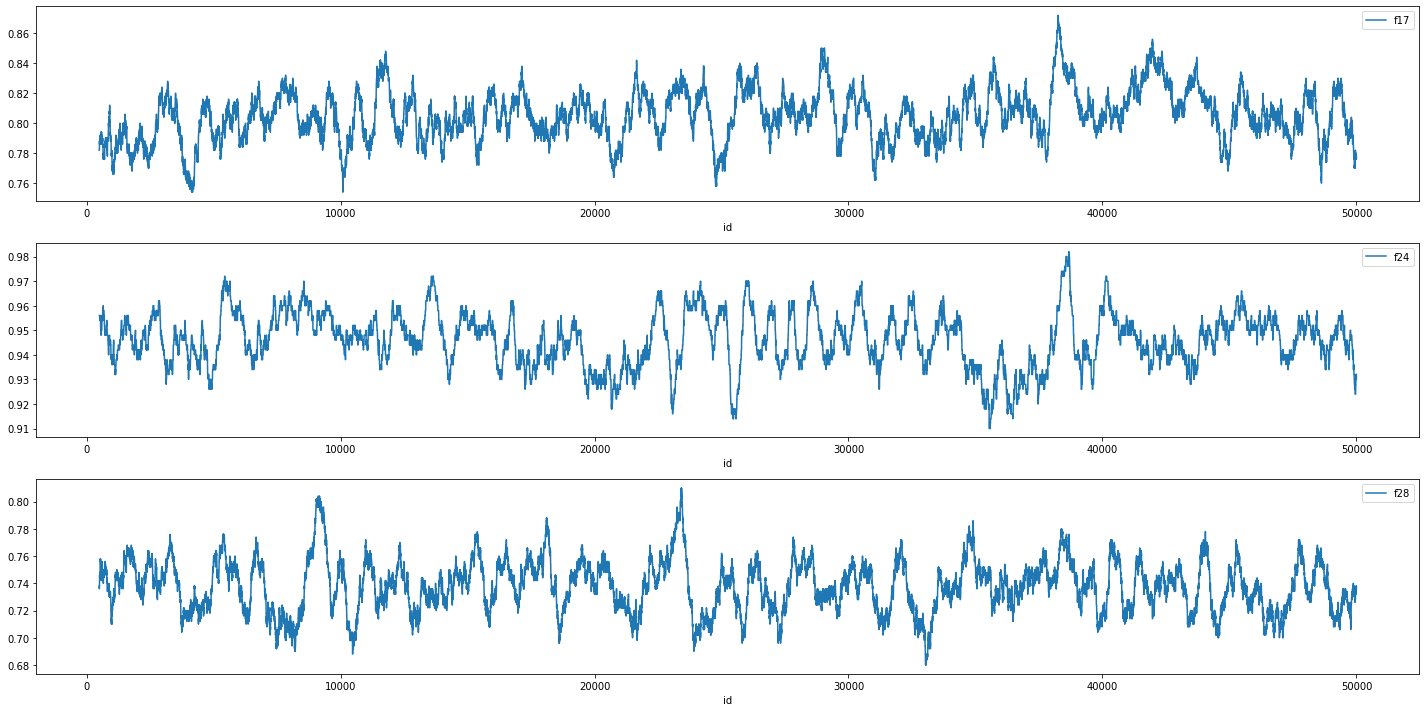

In [90]:
# Make rolling mean plot
features = ['f17', 'f24', 'f28']
fig, axes = plt.subplots(len(features), 1)

for i, feature in enumerate(features):
    training_data[feature].notna().rolling(window=500).mean().plot(ax=axes[i], legend=feature)

plt.tight_layout()
plt.show()

## Explore the hexadecimal features

The features labeled:
- f8 
- f12 
- f14 
- f15 
- f23

All seem to be hexadecimal. These might just be an id of sorts, or anonymized words, or they can be the hex representation of a number.  
An idea can be to covert these into decimal and see if they are important somehow.

Or check if the number of categories increases significantly when we add the test data.

In [91]:
# Check if the number of categories increases when we add the test data 
hexadecimal_features = ['f8', 'f12', 'f14', 'f15', 'f23']
merged_datasets = pd.concat([training_data, X_test])[hexadecimal_features]

merged_statistics = pd.DataFrame(
    {
        '#categories before merge': training_data.nunique(), 
        '#categories after merge': merged_datasets.nunique(),
        'increase': merged_datasets.nunique() - training_data.nunique(),
    }, 
    index=merged_datasets.columns,
)

print(merged_statistics)

     #categories before merge  #categories after merge  increase
f8                       2177                     2203      26.0
f12                       222                      222       0.0
f14                      1204                     1211       7.0
f15                       222                      222       0.0
f23                      1495                     1514      19.0


# Feature engineering

By encoding some of the categorical features, we might be able to see some patterns more clearly and improve the correlation analysis.  
It might also be useful for predictors who only accepts numeric values.

## Convert hexadecimal values to decimal

In [92]:
# Convert hexadecimal numbers to decimal
hexadecimal_features = ['f8', 'f12', 'f14', 'f15', 'f23']

if should_convert['hexadecimal']: 

    func = lambda hex: int(hex, base=16)
    training_data[hexadecimal_features] = training_data[hexadecimal_features].applymap(func, na_action='ignore')
    X_test[hexadecimal_features] = X_test[hexadecimal_features].applymap(func, na_action='ignore')

    training_data[hexadecimal_features].astype(float)
    training_data[hexadecimal_features].astype(float)


In [93]:
# Plot distribution
if should_convert['hexadecimal']: 
    
    fig, axes = plt.subplots(1, len(hexadecimal_features))

    for i, feature in enumerate(hexadecimal_features):
        ax = sns.histplot(training_data[feature], ax=axes[i])
        ax.set_xlabel(feature)
        ax.set_ylabel('')

    plt.show()

## Convert binary numbers to numerical

In [94]:
# Convert binary numbers to decimal
binary_features = ['f20']  # 'f6' is automatically converted by pandas

if should_convert['binary']:

    binary_to_decimal = { 
        0.0: 0, 
        1.0: 1,
        10.0: 2,
        11.0: 3 
    }

    training_data[binary_features[0]] = training_data[binary_features[0]].map(binary_to_decimal, na_action='ignore')
    X_test[binary_features[0]] = X_test[binary_features[0]].map(binary_to_decimal, na_action='ignore')

    training_data[binary_features[0]].astype(float)
    X_test[binary_features[0]].astype(float)

    print(training_data[binary_features[0]].unique())

## Convert alphabetic characters to numbers

In [95]:
# Convert alphabetic characters to numbers: A=0, B=1, ..., Z=25
alphabetic_features = ['f2', 'f10', 'f13', 'f18']

if should_convert['alphabetic']:

    alphabetic_to_ordinal = lambda c: ord(c.lower()) - 97
    training_data[alphabetic_features] = training_data[alphabetic_features].applymap(alphabetic_to_ordinal, na_action='ignore')
    X_test[alphabetic_features] = X_test[alphabetic_features].applymap(alphabetic_to_ordinal, na_action='ignore')

    training_data[alphabetic_features].astype(float)
    X_test[alphabetic_features].astype(float)

## Convert boolean features to numbers

In [96]:
# Convert boolean features to 0.0 and 1.0
boolean_mappings = {
    'f4': {'B': 0.0, 'A': 1.0},
    'f25': {'F': 0.0, 'T': 1.0},
    'f26': {'S': 0.0, 'N': 1.0},
}
boolean_features = boolean_mappings.keys()

if should_convert['boolean']:

    for feature, mapping in boolean_mappings.items():
        training_data[feature] = training_data[feature].map(mapping, na_action='ignore')
        X_test[feature] = X_test[feature].map(mapping, na_action='ignore')
        
        training_data[feature].astype(float)
        X_test[feature].astype(float)

## Decrement f3, f7, and f27 down by one

- f3 ranges from 1-3
- f4 ranges from 1-6
- f27 ranges from 1-4

We shift their scales down by one to make then more comparable to other features which start at 0

In [97]:
# Decrement features by one
features = ['f3', 'f7', 'f27']
decrement_by_one = lambda number: number - 1

training_data[features] = training_data[features].applymap(decrement_by_one, na_action='ignore')
training_data[features].head()

,f3,f7,f27
id,,,
0,2.0,5.0,0.0
1,0.0,3.0,0.0
2,0.0,5.0,2.0
3,2.0,0.0,2.0
4,2.0,5.0,0.0


## Correlation plot of numeric values

Plot with encoded values to look for correlation

<AxesSubplot:>

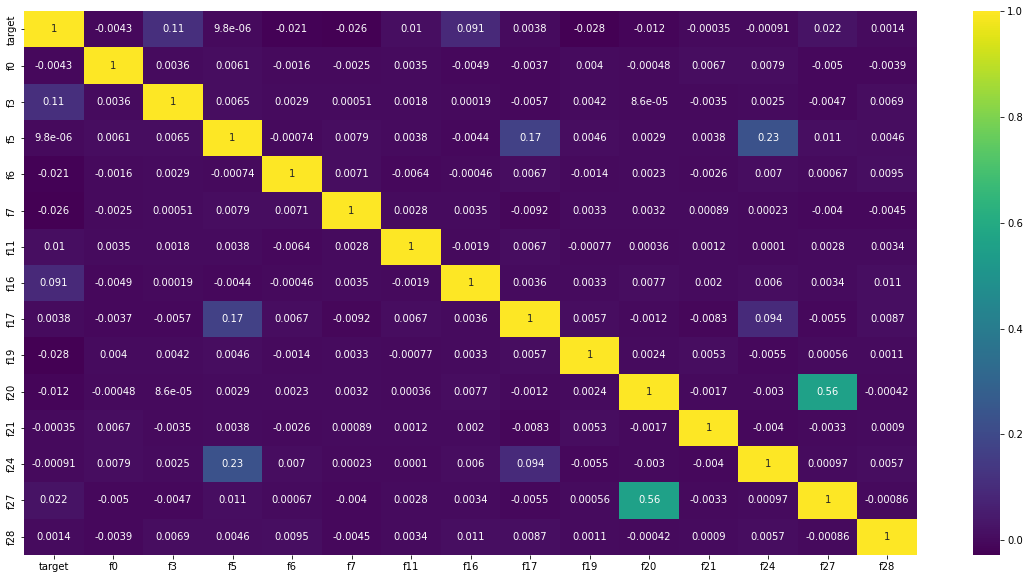

In [98]:
# Correlation plot
correlation = training_data.corr()
sns.heatmap(correlation, annot=True, cmap='viridis')

f20 and f27 have a very high correlation, but they only have four features each.  
We will do some feature pair plots to look for further patterns.

In [99]:
# Take a look at the five most correlated feature pairs
keep = np.triu(np.ones(correlation.shape), k=1).astype('bool').reshape(correlation.size)
correlation = correlation.abs().stack()[keep]  # Only use the lower triangular part of the correlation matrix
correlation = correlation.sort_values(ascending=False)[0:5]  # Only keep top 5
correlation = pd.DataFrame(correlation)
print('The five most correlated features:', correlation)

The five most correlated features:                    0
f20    f27  0.557230
f5     f24  0.231562
       f17  0.171035
target f3   0.109885
f17    f24  0.094405


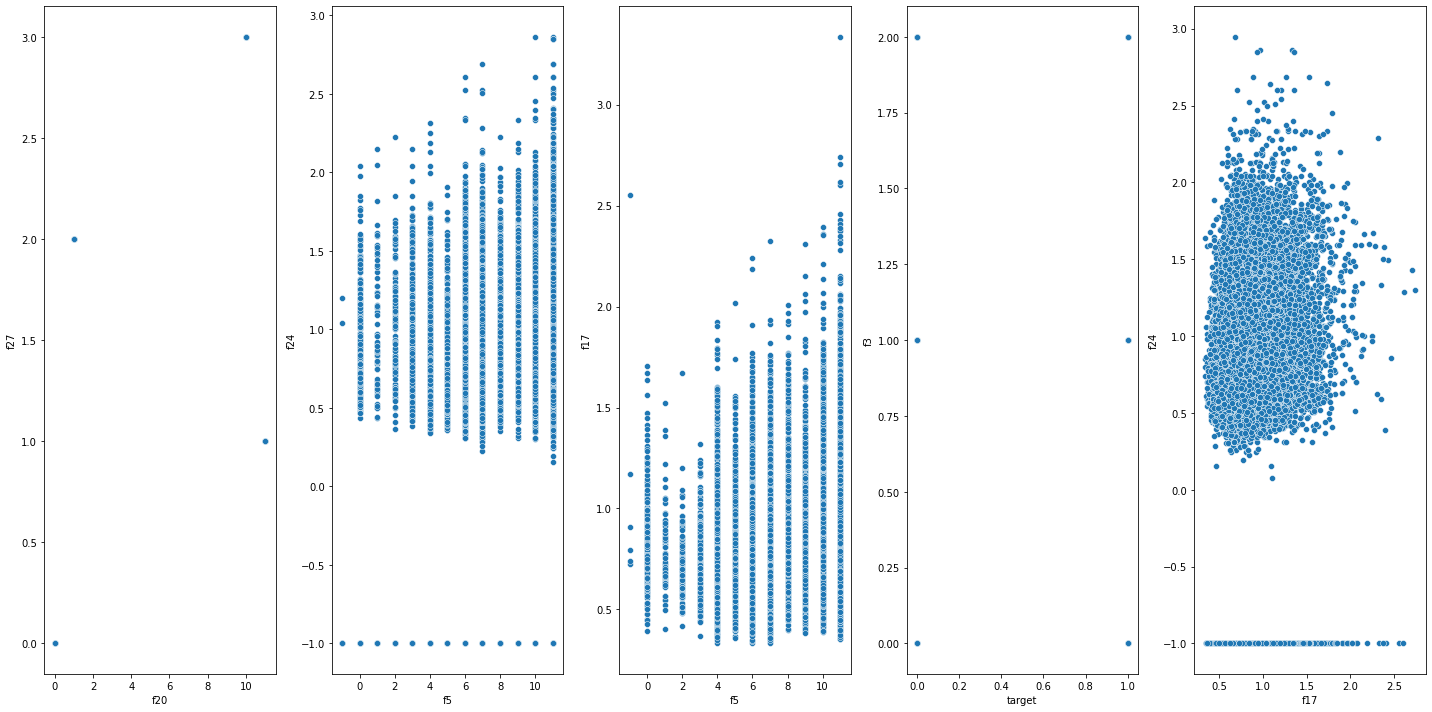

In [100]:
fig, axes = plt.subplots(1, len(correlation))

for i, (feature_x, feature_y) in enumerate(correlation.index):
    ax = sns.scatterplot(data=training_data, x=feature_x, y=feature_y, ax=axes[i])

plt.tight_layout()
plt.show()

The correlation plot shows that **f20** and **f27** have a very high correlation. One of these could be dropped to increase generality (and reduce the computational cost). 

The feature pairs (**f5**, **f24**) and (**f5**, **f17**) tend to increase together
We can also see that the features **f3** and **f16** have a higher correlation with the target value than others, and that we probably should somewhat focus our efforts on these.

# Data cleaning
Data cleaning consists of the following steps
- Removal of unwanted observations
- Fixing structural errors
- Managing unwanted outliers
- Handeling missing data

In [101]:
# Duplicate detection
training_data.duplicated().sum(axis = 0)

0

No duplicate rows in the data set, so no need to remove any rows either.

## Outlier detection and removal

The IQR method is used in this project for outlier detection and removal

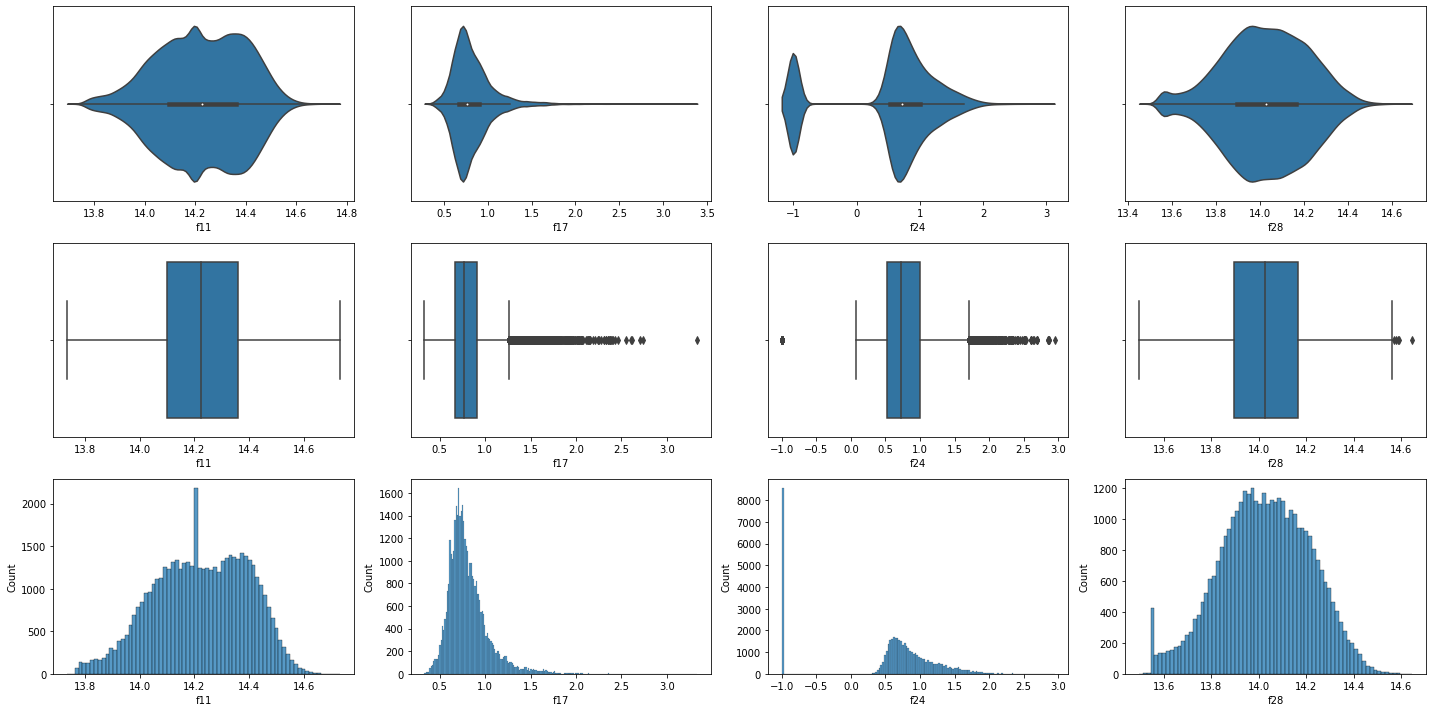

In [102]:
# Plot violin plot, box plot and histplot to show the distribution and outliers
interval_features = ['f11', 'f17', 'f24', 'f28']
fig, axes = plt.subplots(3, len(interval_features))

for i, feature in enumerate(interval_features):
    ax = sns.violinplot(x=training_data[feature], ax=axes[0][i])
    ax = sns.boxplot(x=training_data[feature], ax=axes[1][i])
    ax = sns.histplot(training_data[feature], ax=axes[2][i])

fig.tight_layout()
plt.show()

In [103]:
# Outlier removal by interquartile range (IQR) method
Q1 = training_data[interval_features].quantile(0.25)
Q3 = training_data[interval_features].quantile(0.75)
IQR = Q3 - Q1

# Only remove the "right tail" from the features to keep the -1 value
initial_row_count = training_data.shape[0]
training_data = training_data[~(training_data > (Q3 + 1.5 * IQR)).any(axis=1)]
rows_removed = initial_row_count - training_data.shape[0]
print(f'Rows removed: {rows_removed}')

Rows removed: 2703


Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version.  Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`


## Dealing with missing values

Different predictors have different schemes for handling missing data.  
In this project we have focused on XBoost and CatBoost primarily.

XBoost and CatBoost missing values handled separately before training.
- XGBoost: missing values should be zero
- CatBoost: missing values should be way off the distribution, -999 is often used

## Partition the data into the convectional 'X' and 'y'

In [104]:
# Partition the data
X = training_data.drop(columns=['target']).copy()
y = training_data[['target']].copy()

# Training

## CatBoost

CatBoost expects missing values to be set to a value which is clearly off the distribution of the feature. -999 seems to be a normal choice.  
CatBoost also expects categorical data to be strings. The indices of these also needs to be specified.

### CatBoost specific preprocessing

In [105]:
# CatBoost specific preprocessing

# Imputing
fill_value = -999 

# Make new data sets for CatBoost
X_catboost = X.fillna(fill_value)
X_test_catboost = X_test.fillna(fill_value)

missing_values = pd.DataFrame(
    {
        '#nan_train': X_catboost.isnull().sum(axis = 0),
        '#nan_test': X_catboost.isnull().sum(axis = 0),
    }, 
    index=X_catboost.columns,
)

# Check if there are any missing values left
print(missing_values)

     #nan_train  #nan_test
f0            0          0
f1            0          0
f2            0          0
f3            0          0
f4            0          0
f5            0          0
f6            0          0
f7            0          0
f8            0          0
f9            0          0
f10           0          0
f11           0          0
f12           0          0
f13           0          0
f14           0          0
f15           0          0
f16           0          0
f17           0          0
f18           0          0
f19           0          0
f20           0          0
f21           0          0
f22           0          0
f23           0          0
f24           0          0
f25           0          0
f26           0          0
f27           0          0
f28           0          0


In [ ]:
# Converting numerical features to categorical / "strings"
categorical_numerical_features = []

if not should_convert['binary']:
    categorical_numerical_features += binary_features

if not should_convert['boolean']:
    categorical_numerical_features += ['f0', 'f6']

X_catboost[categorical_numerical_features] = X_catboost[categorical_numerical_features].astype(str)
X_test_catboost[categorical_numerical_features] = X_test_catboost[categorical_numerical_features].astype(str)

# f5 and f28 have many missing values and could be dropped for generality
catboost_dropped_features = ['f13']
X_catboost.drop(catboost_dropped_features, axis=1, inplace=True)
X_test_catboost.drop(catboost_dropped_features, axis=1, inplace=True)
X_catboost.head(5)

### Utility functions

In [184]:
# Utility function to go from, e.g. 'f10' to 10
def features_to_indices(features):
    return [int(column.replace('f', '')) for column in features]

In [185]:
# Utility function to go from, e.g. 10 to 'f10
def indices_to_features(indices):
    return [f'f{index}' for index in indices]

In [186]:
# Utility function for computing the new indices after dropping certain columns
def indices_after_droping(indices, dropped_columns):
    updated_indices = list(indices)
    dropped_indices = features_to_indices(dropped_columns)
    
    for i, old_index in enumerate(indices):
        for column_index in dropped_indices:
            if old_index >= column_index:
                updated_indices[i] -= 1

    return updated_indices

In [187]:
# Find out which features are categorical before training
categorical_features_indices = [1, 9, 22]
categorical_features_indices += features_to_indices(ordinal_features)

if not should_convert['hexadecimal']:
    categorical_features_indices += features_to_indices(hexadecimal_features)

if not should_convert['alphabetic']:
    categorical_features_indices += features_to_indices(alphabetic_features)

if not should_convert['binary']:
    categorical_features_indices += features_to_indices(binary_features)

if not should_convert['boolean']:
    categorical_features_indices += features_to_indices(boolean_features)
    categorical_features_indices += features_to_indices(['f0', 'f6'])

categorical_features_indices = sorted(categorical_features_indices)
print('Categorical features:', categorical_features_indices)

Categorical features: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 18, 20, 21, 22, 23, 25, 26, 27]


### Training CatBoost

In [188]:
from catboost import CatBoostClassifier, metrics
from sklearn.model_selection import train_test_split

# X_train, X_validation, y_train, y_validation = train_test_split(X_catboost, y, train_size=0.8, random_state=42)

catboost_dropped_indices = features_to_indices(catboost_dropped_features)
categorical_features_indices = [index for index in categorical_features_indices if index not in catboost_dropped_indices]
categorical_features_indices_after_dropping = indices_after_droping(categorical_features_indices, catboost_dropped_features)
print(categorical_features_indices_after_dropping)

catboost_model = CatBoostClassifier(
    custom_loss=[metrics.Accuracy()],
    random_seed=RANDOM_SEED,
    logging_level='Silent'
)

catboost_model.fit(
    X_catboost, y,
    cat_features=categorical_features_indices_after_dropping
)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 17, 19, 20, 21, 22, 24, 25, 26]


Accuracy: 82.87%


<AxesSubplot:xlabel='feature_importance'>

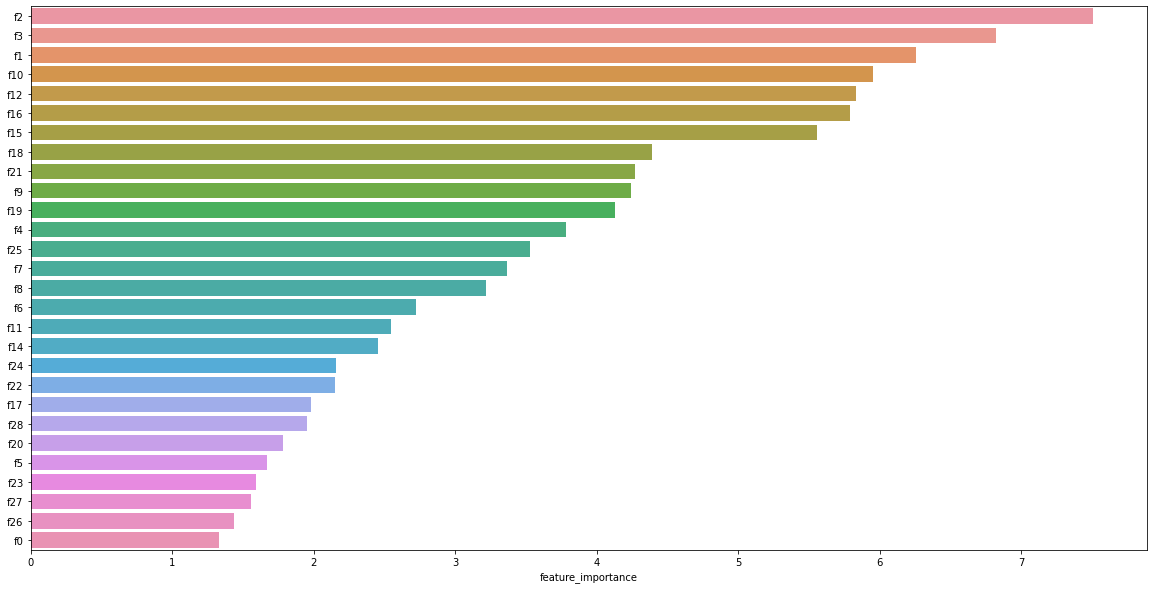

In [191]:
accuracy = catboost_model.get_best_score()['learn']['Accuracy']
print(f'CatBoost classifier accuracy: {accuracy * 100:.2f}%')

feature_importance = pd.DataFrame({'feature_importance': catboost_model.get_feature_importance()}, index=X_catboost.columns)
feature_importance.sort_values(by='feature_importance', ascending=False, inplace=True)
sns.barplot(data=feature_importance, x='feature_importance', y=feature_importance.index)

In [189]:
from catboost import CatBoostRegressor, metrics
from sklearn.model_selection import train_test_split

catboost_regressor = CatBoostRegressor(
    random_seed=RANDOM_SEED,
    logging_level='Silent'
)

catboost_regressor.fit(
    X_catboost, y,
    cat_features=categorical_features_indices_after_dropping,
)

Accuracy: 82.87%


<AxesSubplot:xlabel='feature_importance'>

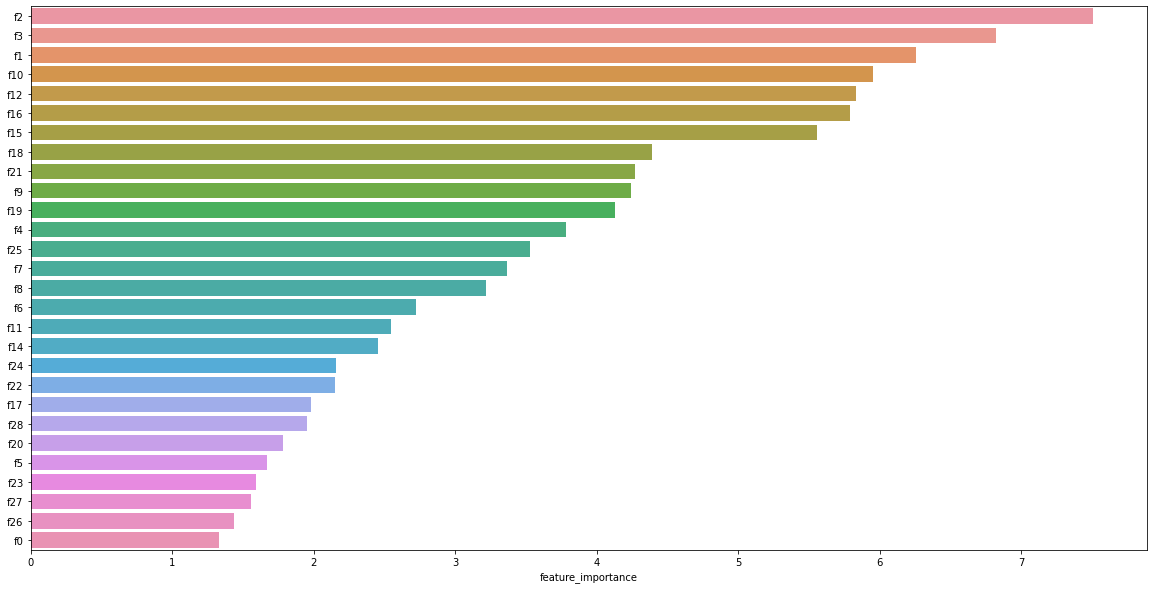

In [ ]:
accuracy = catboost_regressor.get_best_score()['learn']['Accuracy']
print(f'CatBoost regressor accuracy: {accuracy * 100:.2f}%')

feature_importance = pd.DataFrame({'feature_importance': catboost_regressor.get_feature_importance()}, index=X_catboost.columns)
feature_importance.sort_values(by='feature_importance', ascending=False, inplace=True)
sns.barplot(data=feature_importance, x='feature_importance', y=feature_importance.index)

In [190]:
# Stacking several CatBoosts together
from sklearn.linear_model import LogisticRegression
from mlxtend.classifier import StackingCVClassifier

classifiers = [
    CatBoostClassifier(
        cat_features=categorical_features_indices_after_dropping,
        random_seed=RANDOM_SEED,
        logging_level='Silent'
    ),
    CatBoostRegressor(
        cat_features=categorical_features_indices_after_dropping,
        random_seed=RANDOM_SEED,
        logging_level='Silent'
    ),
]

meta_classifier = LogisticRegression()

stacking_model = StackingCVClassifier(classifiers=classifiers, meta_classifier=meta_classifier)

## XGBoost

In [192]:
# # XGBoost requires only numerical features
# # One-hot encode all categorical features
# categorical_features = indices_to_features(categorical_features_indices)
# print(categorical_features_indices)

# X_xgboost = pd.get_dummies(X, columns=categorical_features)
# X_test_xgboost = pd.get_dummies(X_test, columns=categorical_features)

In [193]:
# from xgboost import XGBClassifier

# xgboost_model = XGBClassifier()
# xgboost_model.fit(X_xgboost, y)

# predictions = xgboost_model.predict(X_xgboost)
# accuracy = accuracy_score(y, predictions)
# print("Accuracy: %.2f%%" % (accuracy * 100.0))

# Hyper parameter tuning (CatBoost)

In [194]:
# List all parameters for CatBoost classifier
#CatBoostClassifier?

In [195]:
# from catboost import CatBoostClassifier, metrics
# from sklearn.model_selection import RandomizedSearchCV

# catboost_model = CatBoostClassifier(
#     random_seed=42,
#     logging_level='Silent'
# )

# hyperparameters = {
#     'iterations': [100, 150, 200],
#     'learning_rate': [0.03, 0.1],
#     'depth': [2, 4, 6, 8],
#     'l2_leaf_reg': [0.2, 0.5, 1, 3]
# }

# catboost_hyperparameters = RandomizedSearchCV(
#     estimator=catboost_model, 
#     param_distributions=hyperparameters, 
#     n_iter=100, 
#     scoring='neg_mean_absolute_error', 
#     cv=3, 
#     verbose=2, 
#     random_state=42, 
#     n_jobs=-1,
#     return_train_score=True
# )

# catboost_hyperparameters.fit(X_catboost, y)

In [196]:
# catboost_hyperparameters.best_params_

# Model interpretation

Using a SHapley Additive exPlanations (SHAP) plot to assign an importance value to each feature for a given prediction.

In [197]:
# sorted_feature_importance = catboost_model.get_feature_importance().argsort()
# explainer = shap.TreeExplainer(catboost_model)
# shap_values = explainer.shap_values(X_test_catboost)
# shap.summary_plot(shap_values, X_test_catboost, feature_names=feature_importance.index, max_display=X_test_catboost.shape[1])

In [198]:
#shap.dependence_plot("f2", shap_values, X_catboost)

In [199]:
# # confusion matrix
# from sklearn.metrics import ConfusionMatrixDisplay
# ConfusionMatrixDisplay

## Make predictions

Make predictions from `X_test` and save to file.

In [200]:
# CatBoost
y_pred = catboost_model.predict(X_test_catboost, prediction_type='Probability')
predictions = pd.DataFrame({'id': X_test_catboost.index, 'target': y_pred[:,1]})

predictions.to_csv('../output/catboost.txt', index=False)


# # XGBoost
# y_pred = xgboost_model.predict_proba(X_test_xgboost)
# predictions = pd.DataFrame({'id': X_test_xgboost.index, 'target': y_pred[:,1]})

# predictions.to_csv('../output/xgboost.txt', index=False)

## One-hot encoding
The features labeled:
- f0 (Boolean)
- f1
- f2
- f4
- f9
- f10
- f13
- f18
- f22
- f25 (Boolean)
- f26 (Boolean)

Toghether with the hex features discussed above:
- f8 
- f12 
- f14 
- f15 
- f23


All seem to be categorical and should therefore be converted to one-hot encoding (depending on the learning algorithm).

In [201]:
# One-hot encode categorical features
categorical_features = ['f0', 'f1', 'f2', 'f4', 'f8', 'f9', 'f10', 'f12', 'f13', 'f14', 'f15', 'f18', 'f22', 'f23', 'f25', 'f26']

X_encoded = pd.get_dummies(X, columns=categorical_features)
X_encoded.head()

,f3,f5,f6,f7,f11,f16,f17,f19,f20,f21,...,f23_feea951a9,f23_fef019413,f23_ff6da8268,f23_ff8d3215a,f23_ffe6f54c2,f23_fff06aa8f,f25_F,f25_T,f26_N,f26_S
id,,,,,,,,,,,,,,,,,,,,,
0,3.0,NaN,0.0,6.0,13.9681,2.0,0.858315,0.5,0.0,3.0,...,0,0,0,0,0,0,0,1,1,0
1,1.0,7.0,1.0,4.0,14.0242,NaN,0.616743,0.4,0.0,1.0,...,0,0,0,0,0,0,0,1,1,0
2,1.0,10.0,1.0,6.0,14.2174,3.0,0.711389,0.5,1.0,3.0,...,0,0,0,0,0,0,0,1,1,0
3,3.0,7.0,1.0,1.0,13.8536,5.0,NaN,0.6,1.0,1.0,...,0,0,0,0,0,0,0,1,1,0
4,3.0,7.0,0.0,6.0,14.2347,2.0,0.572781,0.5,0.0,1.0,...,0,0,0,0,0,0,0,1,1,0


In [202]:
# plt.figure(figsize=(32, 12))
# sns.heatmap(training_data.corr(), annot=True, cmap='viridis')

In [203]:
def grade(number_of_vts_beaten):
    a = (100 - 41) / (10 - 1)
    b = 41
    return a * (number_of_vts_beaten - 1) + b

print(grade(7))

# 7 = C
# 8 = B

80.33333333333333
